In [2]:
import numpy as np
import pandas as pd 
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [3]:
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_path = "data/NonLinear_data.npy"
data = np.load(data_path, allow_pickle=True).item()
X, y = data['X'], data['labels']

print(X.shape, y.shape)

(300, 2) (300,)


In [5]:
val_size = 0.2
test_size = 0.125
shuffle = True 

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=shuffle
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val,
    test_size=test_size,
    random_state=random_state,
    shuffle=shuffle
)

In [6]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [7]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X 
        self.y = y 
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx] 

In [18]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        out = self.output(x)    
        return out.squeeze(1)

In [19]:
input_dims = X_train.shape[1]
output_dims = torch.unique(y_train).shape[0]
hidden_dims = 128

model = MLP(input_dims, hidden_dims, output_dims).to(device)

In [20]:
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

def compute_accuracy(y_hat, y_true):
    _, y_pred = y_hat.max(dim=1)
    correct = (y_pred == y_true).sum().item()
    acc = correct / y_true.shape[0]
    return acc

In [21]:
batch_size = 32

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [22]:
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss) 
    
    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)
    
    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()
    
    with torch.no_grad():
            for X_samples, y_samples in val_loader:
                X_samples = X_samples.to(device)
                y_samples = y_samples.to(device)
                outputs = model(X_samples)
                val_loss += criterion(outputs, y_samples).item()
                
                val_predict.append(outputs.cpu())
                val_target.append(y_samples.cpu())
            
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)
    
    print(f"Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

Epoch: 1/100, Train Loss: 0.8082, Val Loss: 0.7913, Train Acc: 0.5708, Val Acc: 0.4231
Epoch: 2/100, Train Loss: 0.7043, Val Loss: 0.7904, Train Acc: 0.5875, Val Acc: 0.4423
Epoch: 3/100, Train Loss: 0.6784, Val Loss: 0.7490, Train Acc: 0.6042, Val Acc: 0.4038
Epoch: 4/100, Train Loss: 0.6842, Val Loss: 0.7312, Train Acc: 0.6417, Val Acc: 0.4231
Epoch: 5/100, Train Loss: 0.6584, Val Loss: 0.7444, Train Acc: 0.5917, Val Acc: 0.6538
Epoch: 6/100, Train Loss: 0.6639, Val Loss: 0.6881, Train Acc: 0.6500, Val Acc: 0.6346
Epoch: 7/100, Train Loss: 0.6203, Val Loss: 0.6673, Train Acc: 0.6667, Val Acc: 0.6346
Epoch: 8/100, Train Loss: 0.5924, Val Loss: 0.6538, Train Acc: 0.6958, Val Acc: 0.6731
Epoch: 9/100, Train Loss: 0.5745, Val Loss: 0.6423, Train Acc: 0.7000, Val Acc: 0.6154
Epoch: 10/100, Train Loss: 0.5654, Val Loss: 0.6366, Train Acc: 0.6958, Val Acc: 0.5192
Epoch: 11/100, Train Loss: 0.5558, Val Loss: 0.6159, Train Acc: 0.7083, Val Acc: 0.5385
Epoch: 12/100, Train Loss: 0.5350, Val Lo

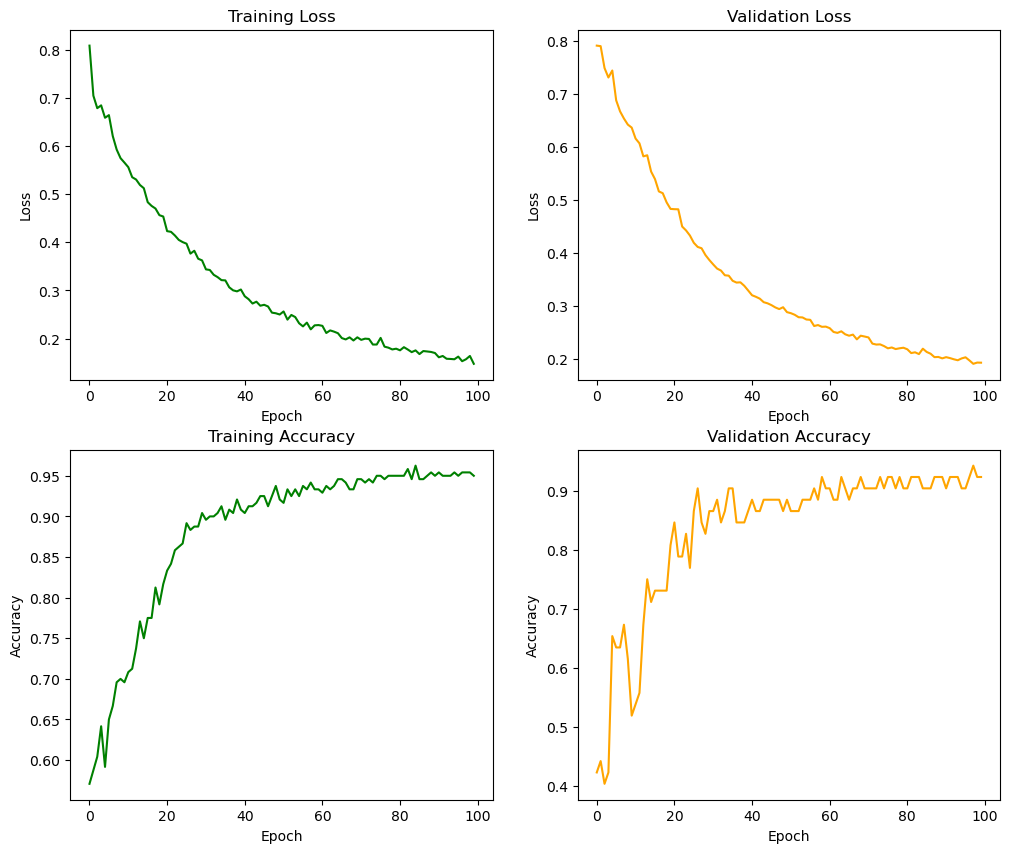

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Training Loss
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

# Validation Loss
ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

# Training Accuracy
ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

# Validation Accuracy
ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

In [24]:
test_target = []
test_predict = []

model.eval()

with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)
        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())
    
    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = compute_accuracy(test_predict, test_target)
    
    print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.8750
